In [24]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


trt_graph = get_frozen_graph('ssd/frozen_inference_graph.pb')

In [236]:
tf_config = tf.ConfigProto()
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

In [256]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]),
                  (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale,
                (255, 255, 255), thickness)

In [158]:
def non_max_suppression(boxes, probs=None, nms_threshold=0.5):
    """Non-max suppression

    Arguments:
        boxes {np.array} -- a Numpy list of boxes, each one are [x1, y1, x2, y2]
    Keyword arguments
        probs {np.array} -- Probabilities associated with each box. (default: {None})
        nms_threshold {float} -- Overlapping threshold 0~1. (default: {0.3})

    Returns:
        list -- A list of selected box indexes.
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    #if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > nms_threshold)[0])))
    # return only the bounding boxes indexes
    return pick


In [237]:
def non_max_suppression(tf_sess, boxes, probs=None, nms_threshold=0.5, iou_threshold=0.5):
    result = tf.image.non_max_suppression(boxes, probs, max_output_size=5, score_threshold=nms_threshold, iou_threshold=iou_threshold)
    #boxes = tf.boolean_mask(boxes, boxes > iou_threshold)
    # boxes = tf_sess.run(boxes)
    res = tf_sess.run(result)
    
    return res

In [8]:
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

In [150]:
tf_boxes

<tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>

In [238]:
input_names = ['image_tensor']
IMAGE_PATH = 'amur/plain_reid_train/train/005154.jpg'

In [254]:
image = cv2.imread(IMAGE_PATH)
image = cv2.resize(image, (300, 300))

In [245]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image[None, ...] # Input needs to be 4D, so reshape to add extra dim
})
boxes = boxes[0]  # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = int(num_detections[0])

In [129]:
def loadLabels(file):
    with open(file) as f:
        lines = [x.split(',') for x in f.readlines()]
        f.close()
    
    mapping = {}
    for line in lines:
        mapping[int(line[0])] = line[1].strip()
    
    return mapping

In [131]:
labels = loadLabels('ssd/label_mapping.csv')

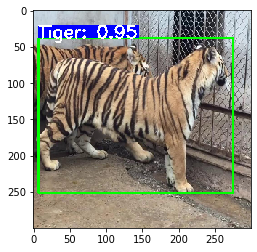

In [257]:
# Boxes unit in pixels (image coordinates).
boxes_pixels = []
for i in range(num_detections):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0],
                               image.shape[1], image.shape[0], image.shape[1]])
    box = np.round(box).astype(int)
    boxes_pixels.append(box)
boxes_pixels = np.array(boxes_pixels)

# Remove overlapping boxes with non-max suppression, return picked indexes.
pick = non_max_suppression(tf_sess, boxes, scores)


for i in pick:
    box = boxes_pixels[i]
    box = np.round(box).astype(int)
    # Draw bounding box.
    image = cv2.rectangle(
        image, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
    label = '{}: {:.2f}'.format(labels[int(classes[i])], scores[i])
    # Draw label (class index andbprobability).
    draw_label(image, (box[1], box[0]), label)

# Save and display the labeled image.
plt.imshow(image[:,:,(2,1,0)])

In [230]:
scores

array([0.9378133, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

In [187]:
res = tf_sess.run(boxes1)

In [227]:
indices = tf.image.non_max_suppression(boxes, scores, max_output_size=5, iou_threshold=0.5, score_threshold=0.5)

In [188]:
res

array([0.81151354, 0.93956536], dtype=float32)

In [176]:
r = tf.gather(boxes, indices)
len(r)

TypeError: object of type 'Tensor' has no len()